#### This notebook is for testing the CRAZY unstable imagery preprocessing pipeline in preprocess.py. Some unstable features will cause this to not work for different imagery sources, imagery sources that have unexpected filenames, etc. Right now, it works for processing the WV2 South Africa dataset for RGB growing season and a single Landsat tile in RGB.

In [1]:
import random
import os
import shutil
import copy
from skimage import measure
from skimage import morphology as skim
import skimage.io as skio
import warnings
import pandas as pd
import numpy as np
import pathlib
import yaml
import geopandas as gpd
from rasterio import features, coords
import rasterio
from shapely.geometry import shape
import gdal

random.seed(1)

def parse_yaml(input_file):
    """Parse yaml file of configuration parameters."""
    with open(input_file, 'r') as yaml_file:
        params = yaml.load(yaml_file)
    return params

params = parse_yaml('preprocess_config.yaml') 

ROOT = params['dirs']['root']

DATASET = os.path.join(
    ROOT, params['dirs']['dataset'])

REORDER = os.path.join(
    DATASET, params['dirs']['reorder'])

TRAIN = os.path.join(
    DATASET, params['dirs']['train'])

TEST = os.path.join(
    DATASET, params['dirs']['test'])

GRIDDED_IMGS = os.path.join(
    DATASET, params['dirs']['gridded_imgs'])

GRIDDED_LABELS = os.path.join(
    DATASET, params['dirs']['gridded_labels'])

OPENED = os.path.join(
    DATASET, params['dirs']['opened'])

NEG_BUFFERED = os.path.join(
    DATASET, params['dirs']['neg_buffered_labels'])

RESULTS = os.path.join(ROOT,'../',params['dirs']['results'], params['dirs']['dataset'])

SOURCE_IMGS = os.path.join(
    ROOT, params['dirs']['source_imgs'])

SOURCE_LABELS = os.path.join(
    ROOT, params['dirs']['source_labels'])

In [2]:
def make_dirs():
    
    dirs = [DATASET, REORDER, TRAIN, TEST, GRIDDED_IMGS, GRIDDED_LABELS, OPENED, NEG_BUFFERED, RESULTS]

    # Make directory and subdirectories
    for d in dirs:
        pathlib.Path(d).mkdir(parents=False, exist_ok=False)

    # Change working directory to project directory
    os.chdir(dirs[0])
make_dirs()

## need a better way of running models with single id than puytting the file name of the reordered file in param?

In [5]:
def yaml_to_band_index(params):
    band_list = []
    if params['image_vals']['dataset'] == 'landsat':
        bands = params['landsat_bands_to_include']
    elif params['image_vals']['dataset'] == 'wv2':
        bands = params['wv2_bands_to_include']
    for i, band in enumerate(bands):
        if list(band.values())[0]== True:
            band_list.append(i)
    return band_list

def reorder_images(params):
    """Load the os, gs, both, or any single date images and subset bands. Growing
    Season is stacked first before OS if both true.
    """
    file_ids_all = next(os.walk(SOURCE_IMGS))[2]
    band_indices = yaml_to_band_index(params)
    if params['seasons']['GS'] or params['seasons']['OS']:
        image_ids_gs = sorted([image_id for image_id in file_ids_all \
                               if 'GS' in image_id and '.aux' not in image_id])
        image_ids_os = sorted([image_id for image_id in file_ids_all \
                               if 'OS' in image_id and '.aux' not in image_id])
    else:
        image_ids = sorted([image_id for image_id in file_ids_all \
                               if '.tif' in image_id and '.aux' not in image_id])
    
    if params['seasons']['GS'] and params['seasons']['OS'] == False:
        for img_path in image_ids_gs:
            gs_image = skio.imread(os.path.join(SOURCE_IMGS, img_path))
            gs_image = gs_image[:,:,band_indices]
            skio.imsave(img_path, gs_image, plugin='tifffile')

    elif params['seasons']['OS'] and params['seasons']['GS'] == False:
        for img_path in image_ids_os:
            os_image = skio.imread(os.path.join(SOURCE_IMGS, img_path))
            os_image = gs_image[:,:,band_indices]
            skio.imsave(img_path, os_image, plugin='tifffile')
    elif params['seasons']['OS'] and params['seasons']['GS']:
        for gs_path, os_path in zip(image_ids_gs, image_ids_os):
            gs_image = skio.imread(os.path.join(SOURCE_IMGS, gs_path))
            os_image = skio.imread(os.path.join(SOURCE_IMGS, os_path))
            gsos_image = np.dstack([gs_image[:,:,band_indices], os_image[:,:,band_indices]])

            match = SequenceMatcher(None, gs_path, os_path).find_longest_match(0, len(gs_path), 0, len(os_path))
            path = gs_path[match.b: match.b + match.size] 
            # this may need to be reworked for diff file names
            # works best if unique ids like GS go in front of filename
            gsos_image_path = os.path.join(REORDER, path + 'OSGS.tif')
            skio.imsave(gsos_image_path, gsos_image, plugin='tifffile')
            
    else: # for non wv2, single date case
            for img_path in image_ids:
                image = skio.imread(os.path.join(SOURCE_IMGS, img_path))
                image = image[:,:,band_indices] # might be best to sav all image bands in each tiff with tile align notebook since we subset here
                skio.imsave(os.path.join(REORDER,img_path), image, plugin='tifffile')
reorder_images(params)

In [6]:
def negative_buffer_and_small_filter(params):
    """
    Applies a negative buffer to labels since some are too close together and 
    produce conjoined instances when connected components is run (even after 
    erosion/dilation). This may not get rid of all conjoinments and should be adjusted.
    It relies too on the source projection of the label file to calculate distances for
    the negative buffer. Currently, if using wv2, labels are reprojected. for other imagery
    it's assumed that the projection is in meters and that a negative buffer in meter units 
    will work with this projection.

    Returns rasterized labels that are ready to be gridded
    
    The function is unfortunately split, one process if the data source is wv2 and one if it is landsat.
    """
    
    class_int = params['label_vals']['class']
    neg_buffer = float(params['label_vals']['neg_buffer'])
    small_area_filter = float(params['label_vals']['small_area_filter'])
    big_area_filter = float(params['label_vals']['big_area_filter'])
    # This is a helper  used with sorted for a list of strings by specific indices in 
    # each string. Was used for a long path that ended with a file name
    # Not needed here but may be with different source imagery and labels
    # def takefirst_two(elem):
    #     return int(elem[-12:-10])

    items = os.listdir(SOURCE_LABELS)
    labels = []
    for name in items:
        if name.endswith(".shp") or name.endswith(".geojson"):
            labels.append(os.path.join(SOURCE_LABELS,name))  

    shp_list = sorted(labels)
    # need to use Source imagery for geotransform data for rasterized shapes, didn't preserve when save imgs to reorder
    scenes = os.listdir(SOURCE_IMGS)
    
    if params['image_vals']['dataset'] =='wv2':
        #hard coded season because it will take more tinkering to have the model and preprocessing work with multichannel
        scenes = [scene for scene in scenes if 'GS' in scene]
        img_list = []
        for name in scenes:
            img_list.append(os.path.join(SOURCE_IMGS,name))  

        img_list = sorted(img_list)


        for shp_path, img_path in zip(shp_list, img_list):
            shp_frame = gpd.read_file(shp_path)
            # keeps the class of interest if it is there and the polygon of raster extent
            shp_frame = shp_frame[(shp_frame['class'] == class_int) | (shp_frame['DN'] == 1)]
            with rasterio.open(img_path) as rast:
                meta = rast.meta.copy()
                meta.update(compress="lzw")
                meta['count'] = 1
            tifname = os.path.splitext(os.path.basename(shp_path))[0] + '.tif'
            rasterized_name = os.path.join(NEG_BUFFERED, tifname)
            with rasterio.open(rasterized_name, 'w+', **meta) as out:
                out_arr = out.read(1)
                # we get bounds to deterimine which projection to use for neg buffer
                shp_frame.loc[0,'DN'] = 0
                shp_frame.loc[1:,'DN'] = 1
                maxx_bound = shp_frame.bounds.maxx.max()
                minx_bound = shp_frame.bounds.minx.min()
                #need to project to correct utm before buffering in units of meters, should move into seperate func
                if maxx_bound >= 30 and minx_bound>= 30:
                    shp_frame = shp_frame.to_crs({'init': 'epsg:32736'})
                    shp_frame['geometry'] = shp_frame['geometry'].buffer(neg_buffer)
                    shp_frame['Shape_Area'] = shp_frame.area
                    shp_frame = shp_frame.to_crs({'init': 'epsg:4326'})

                else:
                    shp_frame = shp_frame.to_crs({'init': 'epsg:32735'})
                    shp_frame['geometry'] = shp_frame['geometry'].buffer(neg_buffer)
                    shp_frame['Shape_Area'] = shp_frame.area
                    shp_frame = shp_frame.to_crs({'init': 'epsg:4326'})

                if len(shp_frame) == 1: # added for case, where entire wv2 scenes have no foreground class and need empty masks
                    shapes = ((geom,value) for geom, value in zip(shp_frame.geometry, shp_frame.DN))
                    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform, default_value=1)
                    burned[burned < 0] = 0
                    out.write_band(1, burned)

                else: # added for center pivot case, where entire wv2 scenes have no center pivots and need empty masks
                    shp_frame = shp_frame.loc[shp_frame.Shape_Area > small_area_filter]
                    shp_frame = shp_frame.loc[shp_frame.Shape_Area < big_area_filter]
                    shp_frame = shp_frame[shp_frame.DN==1] # get rid of extent polygon
                    # https://gis.stackexchange.com/questions/151339/rasterize-a-shapefile-with-geopandas-or-fiona-python#151861
                    shapes = ((geom,value) for geom, value in zip(shp_frame.geometry, shp_frame.DN))
                    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform, default_value=1)
                    burned[burned < 0] = 0
                    out.write_band(1, burned)
        print('Done applying negbuff of {negbuff} and filtering small labels of area less than {area}'.format(negbuff=neg_buffer,area=small_area_filter))  
    
    elif params['image_vals']['dataset'] == 'landsat':
        scenes = [scene for scene in scenes if '.tif' in scene and '.aux' not in scene]
        img_list = []
        for name in scenes:
            img_list.append(os.path.join(SOURCE_IMGS,name))  

        img_list = sorted(img_list)
        for shp_path, img_path in zip(shp_list, img_list):
            shp_frame = gpd.read_file(shp_path)
            # keeps the class of interest if it is there and the polygon of raster extent
            with rasterio.open(img_path) as rast:
                meta = rast.meta.copy()
                meta.update(compress="lzw")
                meta['count'] = 1
                tifname = os.path.splitext(os.path.basename(shp_path))[0] + '.tif'
                rasterized_name = os.path.join(NEG_BUFFERED, tifname)
                with rasterio.open(rasterized_name, 'w+', **meta) as out:
                    out_arr = out.read(1)
                    shp_frame = shp_frame.loc[shp_frame.area > small_area_filter]
                    shp_frame = shp_frame.loc[shp_frame.area < big_area_filter]
                    shp_frame['geometry'] = shp_frame['geometry'].buffer(neg_buffer)
                    # https://gis.stackexchange.com/questions/151339/rasterize-a-shapefile-with-geopandas-or-fiona-python#151861
                    shapes = ((geom,value) for geom, value in zip(shp_frame.geometry, shp_frame.ObjectID))
                    burned = features.rasterize(shapes=shapes, fill=0, out_shape=rast.shape, transform=out.transform, default_value=1)
                    burned[burned < 0] = 0
                    burned[burned > 0] = 1
                    burned = burned.astype(np.int16, copy=False)
                    out.write(burned, 1)
        print('Done applying negbuff of {negbuff} and filtering small labels of area less than {area}'.format(negbuff=neg_buffer,area=small_area_filter)) 
        
negative_buffer_and_small_filter(params)

Done applying negbuff of -30.0 and filtering small labels of area less than 100.0


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


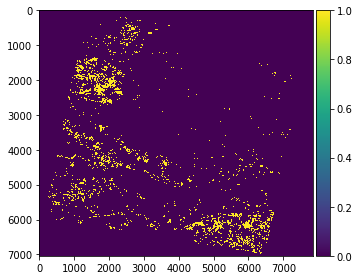

In [8]:
#skio.imshow(skio.imread("/home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/neg_buffered_labels/LT05_L1TP_032031_20040926_20160913_labels.tif"))

In [7]:
def rm_mostly_empty(scene_path, label_path):
    '''
    Removes a grid that is mostly (over 1/4th) empty and corrects bad no data value to 0.
    Ignor ethe User Warning, unsure why it pops up but doesn't seem to impact the array shape
    '''
    
    usable_data_threshold = params['image_vals']['usable_thresh']
    arr = skio.imread(scene_path)
    arr[arr<0] = 0
    skio.imsave(scene_path, arr)
    pixel_count = arr.shape[0] * arr.shape[1]
    nodata_pixel_count = (arr == 0).sum()
    if 1-(nodata_pixel_count/pixel_count) < usable_data_threshold:

        os.remove(scene_path)
        os.remove(label_path)
        print('removed scene and label, over {}% bad data'.format(usable_data_threshold))

def grid_images(params):
    """
    Grids up imagery to a variable size. Filters out imagery with too little usable data.
    appends a random unique id to each tif and label pair, appending string 'label' to the 
    mask.
    """
    if params['image_vals']['img_id'] is str:
        img_list = [params['image_vals']['img_id']]
        label_list = sorted(next(os.walk(NEG_BUFFERED))[2])
        print("label list definiton for single id should change later to specifically reference the id!")
    else:
        img_list = sorted(next(os.walk(REORDER))[2])
        label_list = sorted(next(os.walk(NEG_BUFFERED))[2])
    for img_name, label_name in zip(img_list, label_list):
        img_path = os.path.join(REORDER, img_name)
        label_path = os.path.join(NEG_BUFFERED, label_name)
        #assign unique name to each gridded tif, keeping season suffix
        #assigning int of same length as ZA0932324 naming convention
        
        tile_size_x = params['image_vals']['grid_size']
        tile_size_y = params['image_vals']['grid_size']
        ds = gdal.Open(img_path)
        band = ds.GetRasterBand(1)
        xsize = band.XSize
        ysize = band.YSize   
        
        for i in range(0, xsize, tile_size_x):
            for j in range(0, ysize, tile_size_y):
                unique_id = str(random.randint(100000000,999999999))
                out_path_img = os.path.join(GRIDDED_IMGS,unique_id)+ '.tif'
                out_path_label = os.path.join(GRIDDED_LABELS,unique_id)+ '_label.tif'
                com_string = "gdal_translate -of GTIFF -srcwin " + str(i)+ ", " + \
                    str(j) + ", " + str(tile_size_x) + ", " + str(tile_size_y) + " " + \
                    str(img_path) + " " + str(out_path_img)
                os.system(com_string)
                com_string = "gdal_translate -of GTIFF -srcwin " + str(i)+ ", " + \
                    str(j) + ", " + str(tile_size_x) + ", " + str(tile_size_y) + " " + \
                    str(label_path) + " " + str(out_path_label)
                os.system(com_string)
                rm_mostly_empty(out_path_img, out_path_label)
                
grid_images(params)

/opt/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (512, 512, 3) to (7041, 7841, 3)
  warnings.warn(str(e))
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/244272509.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/711178002.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/961425548.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/920096753.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/167760436.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/373878287.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/226614242.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/631969374.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/917077201.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/582637352.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/607069464.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/799642630.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/507608741.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/946885253.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/325437259.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/200780963.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/623832096.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/130437866.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/997395948.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/518554019.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/564680097.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/752231581.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/918492001.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/923729238.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/102261353.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/s

removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/385970256.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/874747711.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/960954509.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/345631564.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/734746160.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/209765575.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/440837476.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/s

removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/837106430.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/332571831.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/553244221.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/879378296.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/131182305.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/s

removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/826760591.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/334914346.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/917061414.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/593495461.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/411150634.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/123074397.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/s

removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/418246764.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/229804604.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/897947650.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/457228733.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/874687978.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/863636349.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/s

removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/730909864.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/636185925.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/642544369.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/522360239.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/732436358.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/137071829.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/s

removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/494196212.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/689268179.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/854884265.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/933049334.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/824223642.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/892652820.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/s

removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/522254446.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/497845686.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/625804415.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/886801296.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/131755873.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/s

removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/282911059.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/281026748.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/639274549.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/343672113.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/113208723.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/s

removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/479325246.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/592988938.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/389136634.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/807826512.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/688406554.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/753849522.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/s

removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/238780515.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/656926566.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/934723866.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/702753419.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/320638116.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/557511382.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/s

removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/620684370.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/973329535.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/483100304.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/544984939.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/471598338.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/101701610.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/s

removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/130037904.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/963899905.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/346536523.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/782224519.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/290279142.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/691370036.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/s

removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/957317285.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/691663028.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/955876987.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/976642949.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/374119888.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/134852725.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/822750144.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/175648841.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/189371972.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/117921429.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/586403747.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/115633654.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/909757328.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/911305121.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/401932634.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/367962176.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/388451869.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/217562515.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/956081167.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/770876131.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/298223673.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/469821234.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/411690423.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/174641570.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/279819878.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/271396602.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/374036219.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/666270385.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/280544260.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/805079554.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/393039647.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/796002456.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


removed scene and label, over 0.01% bad data
removed scene and label, over 0.01% bad data


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/cropmask/data/landsat-1024-cp/landsat_grid_imgs/864063871.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [8]:
def open_labels(params):
    """
    Opens labels with kernel as defined in config.
    """
    k = params['label_vals']['kernel']
    label_list = next(os.walk(GRIDDED_LABELS))[2]
    if params['label_vals']['open'] == True:
        for name in label_list:
            arr = skio.imread(os.path.join(GRIDDED_LABELS,name))
            arr[arr < 0]=0
            opened_path = os.path.join(OPENED,name)
            kernel = np.ones((k,k))
            arr = skim.binary_opening(arr, kernel)
            arr=1*arr
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                skio.imsave(opened_path, 1*arr)

        print('Done opening with kernel of h and w {size}'.format(size=k))

    else:
        for name in label_list:
            arr = skio.imread(os.path.join(GRIDDED_LABELS,name))
            arr[arr < 0]=0
            opened_path = os.path.join(OPENED,name)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                skio.imsave(opened_path, 1*arr)    
open_labels(params)

In [9]:
def move_img_to_folder(params):
    '''Moves a file with identifier pattern 760165086_OSGS.tif 
    (or just760165086.tif) to a 
    folder path ZA0165086/image/ZA0165086.tif
    Also creates a mask folder at ZA0165086/masks
    '''
    
    image_list = os.listdir(GRIDDED_IMGS)
    for img in image_list:

        folder_name = os.path.join(TRAIN,img[:9])
        os.mkdir(folder_name)
        new_path = os.path.join(folder_name, 'image')
        mask_path = os.path.join(folder_name, 'mask')
        os.mkdir(new_path)
        file_path = os.path.join(GRIDDED_IMGS,img)
        os.rename(file_path, os.path.join(new_path, img[:9]+'.tif'))
        os.mkdir(mask_path)
move_img_to_folder(params)

In [10]:
def connected_comp(params):
    """
    Extracts individual instances into their own tif files. Saves them
    in each folder ID in train folder. If an image has no instances,
    saves it with a empty mask.
    """
    label_list = next(os.walk(OPENED))[2]
    # save connected components and give each a number at end of id
    for name in label_list:
        arr = skio.imread(os.path.join(OPENED,name))
        blob_labels = measure.label(arr, background=0)
        blob_vals = np.unique(blob_labels)
        #for imgs with no isntances, create empty mask
        if len(blob_vals)==1:
            img_folder = os.path.join(TRAIN,name[:9], 'image')
            img_name = os.listdir(img_folder)[0]
            img_path = os.path.join(img_folder, img_name)
            arr = skio.imread(img_path)
            mask = np.zeros_like(arr[:,:,0])
            mask_folder = os.path.join(TRAIN,name[:9], 'mask')
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                label_stump = os.path.splitext(os.path.basename(name))[0]
                skio.imsave(os.path.join(mask_folder,  label_stump + '_0.tif'),mask)
        # only run connected comp if there is at least one instance
        for blob_val in blob_vals[blob_vals!=0]:
            labels_copy = blob_labels.copy()
            labels_copy[blob_labels!=blob_val] = 0
            labels_copy[blob_labels==blob_val] = 1

            label_stump = os.path.splitext(os.path.basename(name))[0]
            label_name = label_stump+'_'+str(blob_val)+'.tif'
            mask_path = os.path.join(TRAIN,name[:9], 'mask')
            label_path = os.path.join(mask_path,label_name)
            assert labels_copy.ndim == 2
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                skio.imsave(label_path, labels_copy)
                
connected_comp(params)

In [11]:
def train_test_split(params):
    """Takes a sample of folder ids and copies them to a test directory
    from a directory with all folder ids. Each sample folder contains an 
    images and corresponding masks folder."""

    k = params['image_vals']['split']
    sample_list = next(os.walk(TRAIN))[1]
    k = round(k*len(sample_list))
    test_list = random.sample(sample_list,k)
    for test_sample in test_list:
        shutil.copytree(os.path.join(TRAIN,test_sample),os.path.join(TEST,test_sample))
    train_list = list(set(next(os.walk(TRAIN))[1]) - set(next(os.walk(TEST))[1]))
    train_df = pd.DataFrame({'train': train_list})
    test_df = pd.DataFrame({'test': test_list})
    train_df.to_csv(os.path.join(RESULTS, 'train_ids.csv'))
    test_df.to_csv(os.path.join(RESULTS, 'test_ids.csv'))
train_test_split(params)

In [12]:
def get_arr_channel_mean(channel):
    """
    Calculate the mean of a given channel across all training samples.
    """
     
    means = []
    train_list = list(set(next(os.walk(TRAIN))[1]) - set(TEST))
    for i, fid in enumerate(train_list):
        im_folder = os.path.join(TRAIN,fid, 'image')
        im_path = os.path.join(im_folder, os.listdir(im_folder)[0])
        arr = skio.imread(im_path)
        arr = arr.astype(np.float32,copy=False)
        # added because no data values different for wv2 and landsat, need to exclude from mean
        nodata_value = arr.min() if arr.min() < 0 else -9999 
        arr[arr==nodata_value]=np.nan
        means.append(np.nanmean(arr[:,:,channel]))
    print(np.mean(means))
band_indices = yaml_to_band_index(params)
for i, v in enumerate(band_indices):
    get_arr_channel_mean(i)

697.55347
986.7377
1137.1453


In [23]:
if __name__ == '__main__':
    make_dirs()
    reorder_images(params)
    negative_buffer_and_small_filter(params)
    grid_images(params)
    open_labels(params)
    move_img_to_folder(params)
    connected_comp(params)
    train_test_split(params)
    print('preprocessing complete, ready to run model.')

    print('channel means, put these in model_configs.py subclass')
    band_indices = yaml_to_band_index(params)
    for i, v in enumerate(band_indices):
        get_arr_channel_mean(i)

In [53]:
band_indices = yaml_to_band_index(params)
for i, v in enumerate(band_indices):
    get_arr_channel_mean(i)

12555.537
8340.699
8314.736
